In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime
import json
import ppscore

In [2]:
df = pd.read_csv(r'C:\Users\colem\OneDrive\Documents\Springboard\COVID-19-master\covid_data_cleaned.csv')

In [3]:
df.head()

,Province_State,Last_Update,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate
0,North Carolina,2021-01-02 05:30:44,539545,6748,403488.0,129309.0,5144.361925,6944103.0,NaN,1.250683,66209.452556,NaN,NaN,NaN
1,North Carolina,2022-01-02 04:32:57,1686667,19426,NaN,NaN,16081.745722,18909822.0,NaN,1.151739,180298.155507,NaN,NaN,NaN
2,North Carolina,2021-01-03 05:30:33,558437,6892,403488.0,148057.0,5324.490155,7079384.0,NaN,1.234159,67499.306832,NaN,NaN,NaN
3,North Carolina,2022-01-03 02:33:49,1686667,19426,NaN,NaN,16081.745722,18909822.0,NaN,1.151739,180298.155507,NaN,NaN,NaN
4,North Carolina,2021-01-04 05:30:45,564924,6910,403488.0,154526.0,5386.341299,7132661.0,NaN,1.223173,68007.283313,NaN,NaN,NaN


Checking for null values

In [4]:
df.isnull().any()

Province_State          False
Last_Update             False
Confirmed               False
Deaths                  False
Recovered                True
Active                   True
Incident_Rate           False
Total_Test_Results       True
People_Hospitalized      True
Case_Fatality_Ratio      True
Testing_Rate            False
Hospitalization_Rate     True
People_Tested            True
Mortality_Rate           True
dtype: bool

Dropping columns that are incomplete and Province_State.

In [5]:
df = df.drop(columns = ['Province_State', 'People_Hospitalized', 'Hospitalization_Rate', 'People_Tested', 'Mortality_Rate', 'Recovered', 'Active', 'Total_Test_Results', 'Case_Fatality_Ratio'])

Double checking data types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Last_Update    728 non-null    object 
 1   Confirmed      728 non-null    int64  
 2   Deaths         728 non-null    int64  
 3   Incident_Rate  728 non-null    float64
 4   Testing_Rate   728 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 28.6+ KB


Converting Last_update to datetime as that was lost when csv was saved. Converting Confirmed and Deaths to float for ease in calculations.

In [7]:
df['Last_Update']= pd.to_datetime(df['Last_Update'])
df['Confirmed']=df['Confirmed'].astype('float')
df['Deaths']=df['Deaths'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Last_Update    728 non-null    datetime64[ns]
 1   Confirmed      728 non-null    float64       
 2   Deaths         728 non-null    float64       
 3   Incident_Rate  728 non-null    float64       
 4   Testing_Rate   728 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 28.6 KB


Removing time of day from Last_Update column and renaming it to Date

In [8]:
df['Date'] = df['Last_Update'].dt.date
df['Date']= pd.to_datetime(df['Date'])

Changing index to Last Update and sorting by index

In [9]:
df.set_index('Date', drop = True, append = False, inplace = True, verify_integrity = False)
df.sort_values(by = "Date", inplace=True)
df.head()

,Last_Update,Confirmed,Deaths,Incident_Rate,Testing_Rate
Date,,,,,
2020-04-12,2020-04-12 23:18:15,4570.0,89.0,43.573259,626.535422
2020-04-13,2020-04-13 23:07:54,4886.0,94.0,46.586202,639.128846
2020-04-14,2020-04-14 23:33:31,5113.0,112.0,48.750563,655.775557
2020-04-15,2020-04-15 22:56:51,5340.0,130.0,50.914924,683.886417
2020-04-16,2020-04-16 23:30:51,5639.0,150.0,53.765778,715.042285


Creating new variables New_Confirmed and New_Deaths containing the difference in daily deaths and confirmed

In [10]:
df['New_Confirmed'] = df['Confirmed']-df['Confirmed'].shift(+1)
df['New_Deaths'] = df['Deaths']-df['Deaths'].shift(+1)
df.head()

,Last_Update,Confirmed,Deaths,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths
Date,,,,,,,
2020-04-12,2020-04-12 23:18:15,4570.0,89.0,43.573259,626.535422,NaN,NaN
2020-04-13,2020-04-13 23:07:54,4886.0,94.0,46.586202,639.128846,316.0,5.0
2020-04-14,2020-04-14 23:33:31,5113.0,112.0,48.750563,655.775557,227.0,18.0
2020-04-15,2020-04-15 22:56:51,5340.0,130.0,50.914924,683.886417,227.0,18.0
2020-04-16,2020-04-16 23:30:51,5639.0,150.0,53.765778,715.042285,299.0,20.0


Dropping cumulative columns

In [11]:
df = df.drop(columns = ['Confirmed','Deaths'])

First glance at summary statistics

In [12]:
df.describe()

,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths
count,728.000000,728.000000,727.000000,727.000000
mean,9042.757699,98525.063272,3616.832187,31.867950
std,7267.680423,67058.785147,7833.537271,34.566806
min,43.573259,626.535422,0.000000,-3.000000
25%,2202.892826,32216.477767,509.500000,6.500000
50%,8861.542299,102645.640519,1740.000000,22.000000
75%,13587.438850,153027.016183,3754.000000,44.000000
max,25114.282075,218111.868669,119101.000000,181.000000


There is at least one negative New_Deaths entry that needs fixing. (Can't have negative deaths). Checking for total number of negative New_Deaths

In [13]:
New_Deaths_Negative = df[df['New_Deaths']<0]
New_Deaths_Negative

,Last_Update,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths
Date,,,,,
2020-06-29,2020-06-29 04:33:57,593.511646,8313.291541,1436.0,-1.0
2021-07-02,2021-07-02 04:31:14,9667.971767,118762.263918,296.0,-3.0


Two dates have negative New_Deaths. One on a day with minimal confirmed cases one on a day with high number of confirmed cases. Okay to fill with zeros because values are not very large (-1 and -3) and we will be doing most of our visualization on weekly and monthly basis'. This also ensures it does not mess up the weekly totals by adding in deaths that didn't occur.

In [14]:
df['New_Deaths'].replace([-1,-3], 0).head(0)

Series([], Name: New_Deaths, dtype: float64)

quick check of tail of data

In [15]:
df.tail(24)

,Last_Update,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths
Date,,,,,
2022-03-18,2022-03-18 04:31:31,24934.239657,214851.787991,2742.0,64.0
2022-03-19,2022-03-19 04:32:16,24950.829913,215078.941015,1740.0,28.0
2022-03-20,2022-03-20 04:32:01,24950.829913,215290.342831,0.0,0.0
2022-03-21,2022-03-21 04:31:09,24950.829913,215290.342831,0.0,0.0
2022-03-22,2022-03-22 04:31:02,24974.742765,215290.342831,2508.0,20.0
2022-03-23,2022-03-23 04:31:22,24982.551627,215791.149270,819.0,13.0
2022-03-24,2022-03-24 04:31:09,24997.826104,215862.506441,1602.0,39.0
2022-03-25,2022-03-25 04:31:26,25010.106708,216011.418291,1288.0,29.0
2022-03-26,2022-03-26 04:31:08,25021.777095,216226.128624,1224.0,15.0


Noticed that most weeks have 2 days in a row with no reported data. Decide to check which day.

In [16]:
df['Day_Of_Week'] = df.index.dayofweek
df.tail(21)

,Last_Update,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths,Day_Of_Week
Date,,,,,,
2022-03-21,2022-03-21 04:31:09,24950.829913,215290.342831,0.0,0.0,0
2022-03-22,2022-03-22 04:31:02,24974.742765,215290.342831,2508.0,20.0,1
2022-03-23,2022-03-23 04:31:22,24982.551627,215791.149270,819.0,13.0,2
2022-03-24,2022-03-24 04:31:09,24997.826104,215862.506441,1602.0,39.0,3
2022-03-25,2022-03-25 04:31:26,25010.106708,216011.418291,1288.0,29.0,4
2022-03-26,2022-03-26 04:31:08,25021.777095,216226.128624,1224.0,15.0,5
2022-03-27,2022-03-27 04:31:23,25021.777095,216226.128624,0.0,0.0,6
2022-03-28,2022-03-28 04:31:10,25021.777095,216226.128624,0.0,0.0,0
2022-03-29,2022-03-29 04:31:12,25043.620932,216226.128624,2291.0,16.0,1


Looks like North Carolina didn't report on Sunday and Monday. Lets make sure

In [17]:
df.groupby(['Day_Of_Week']).agg(lambda x: x.eq(0).sum())

,Last_Update,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths
Day_Of_Week,,,,,
0,0,0,0,58,58
1,0,0,0,6,6
2,0,0,0,0,1
3,0,0,0,1,1
4,0,0,0,6,6
5,0,0,0,6,7
6,0,0,0,55,55


Looks like the majority of the time the days where NC did not report were Sunday and Monday but there were certainly some exceptions. We do know that cumulative values are posted however so we can assume that after a day or multiple days of not being reported we would have the sum of the missing days on the day following. Let's start by removing the last 3 days because we have no "day after" to use to adjust those.

In [18]:
df.drop(df.tail(3).index, inplace = True)

It appears that Confirmed and Deaths for the missing days are reported on the following active day. Decide to loop through the data and check if it is 3, 2 or 1 consecutive non-reported days and then take a equal portion of the following day to replace those values with.

In [19]:
for i,(index, row) in enumerate(df.iterrows()):
    if i-3 < 0:
        continue 
    if ((df.iloc[i-1]['New_Confirmed'] + df.iloc[i-2]['New_Confirmed'] + df.iloc[i-3]['New_Confirmed']) == 0):
        New_Confirmed_Var = (df.iloc[i]['New_Confirmed'])/4
        New_Death_Var = df.iloc[i]['New_Deaths']/4
        df.iloc[i,4] = New_Death_Var
        df.iloc[i-1,4] = New_Death_Var
        df.iloc[i-2,4] = New_Death_Var
        df.iloc[i-3,4] = New_Death_Var
        df.iloc[i,3] = New_Confirmed_Var
        df.iloc[i-1,3] = New_Confirmed_Var
        df.iloc[i-2,3] = New_Confirmed_Var
        df.iloc[i-3,3] = New_Confirmed_Var

In [20]:
for i,(index, row) in enumerate(df.iterrows()):
    if i-2 < 0:
        continue 
    if ((df.iloc[i-1]['New_Confirmed'] + df.iloc[i-2]['New_Confirmed']) == 0):
        New_Confirmed_Var = (df.iloc[i]['New_Confirmed'])/3
        New_Death_Var = df.iloc[i]['New_Deaths']/3
        df.iloc[i,4] = New_Death_Var
        df.iloc[i-1,4] = New_Death_Var
        df.iloc[i-2,4] = New_Death_Var
        df.iloc[i,3] = New_Confirmed_Var
        df.iloc[i-1,3] = New_Confirmed_Var
        df.iloc[i-2,3] = New_Confirmed_Var

In [21]:
for i,(index, row) in enumerate(df.iterrows()):
    if i-1 < 0:
        continue 
    if ((df.iloc[i-1]['New_Confirmed']) == 0):
        New_Confirmed_Var = (df.iloc[i]['New_Confirmed'])/2
        New_Death_Var = df.iloc[i]['New_Deaths']/2
        df.iloc[i,4] = New_Death_Var
        df.iloc[i-1,4] = New_Death_Var
        df.iloc[i,3] = New_Confirmed_Var
        df.iloc[i-1,3] = New_Confirmed_Var

In [22]:
df.tail(14)

,Last_Update,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths,Day_Of_Week
Date,,,,,,
2022-03-25,2022-03-25 04:31:26,25010.106708,216011.418291,1288.000000,29.000000,4
2022-03-26,2022-03-26 04:31:08,25021.777095,216226.128624,1224.000000,15.000000,5
2022-03-27,2022-03-27 04:31:23,25021.777095,216226.128624,763.666667,5.333333,6
2022-03-28,2022-03-28 04:31:10,25021.777095,216226.128624,763.666667,5.333333,0
2022-03-29,2022-03-29 04:31:12,25043.620932,216226.128624,763.666667,5.333333,1
2022-03-30,2022-03-30 04:31:31,25049.570541,216939.128253,624.000000,4.000000,2
2022-03-31,2022-03-31 04:31:16,25059.743991,217016.225271,1067.000000,9.000000,3
2022-04-01,2022-04-01 04:31:29,25069.993719,217142.368425,1075.000000,4.000000,4
2022-04-02,2022-04-02 04:31:55,25080.901335,217331.297118,1144.000000,8.000000,5


Checking New_Confirmed to make sure replacement worked.

In [23]:
df = df.drop(columns='Last_Update')
df.groupby(['Day_Of_Week']).agg(lambda x: x.eq(0).sum())

,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths
Day_Of_Week,,,,
0,0,0,0,0
1,0,0,0,0
2,0,0,0,1
3,0,0,0,0
4,0,0,0,0
5,0,0,0,1
6,0,0,0,0


In [24]:
token = ''

In [25]:
#empty lists to fill later
nc_dates_temp_max = []
nc_dates_temp_min = []
nc_dates_prcp = []
nc_temps_min = []
nc_temps_max = []
nc_prcp = []
#creating loop to grab one year of data at a time
for year in range (2020, 2023):
    year = str(year)
    #api call
    r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TMAX&datatypeid=TMIN&datatypeid=PRCP&limit=1000&stationid=GHCND:USW00013881&startdate='+year+'-01-01&enddate='+year+'-12-31', headers = {'token' : token})
    #loading api call as a json
    d = json.loads(r.text)
    #getting all minimum temperature items
    nc_min_temps_item = [item for item in d['results'] if item['datatype']=='TMIN']
    #getting the date field from the minimum temperature readings
    nc_dates_temp_min += [item['date'] for item in nc_min_temps_item]
    #getting the actual minimum temperature 
    nc_temps_min += [item['value'] for item in nc_min_temps_item]
    #getting all maximum temperature items
    nc_max_temps_item = [item for item in d['results'] if item['datatype']=='TMAX']
    #getting the date field from the maximum temperature readings
    nc_dates_temp_max += [item['date'] for item in nc_max_temps_item]
    #getting the actual maximum temperature
    nc_temps_max += [item['value'] for item in nc_max_temps_item]
    #getting all average precipitation items
    nc_avg_prcp = [item for item in d['results'] if item ['datatype'] == 'PRCP']
    #getting the date field from the precipitation readings
    nc_dates_prcp += [item['date'] for item in nc_avg_prcp]
    #getting the actual precipitation
    nc_prcp += [item['value'] for item in nc_avg_prcp]

In [26]:
#Zipping dates together & converting to datetime format
df_nc_temp_min = pd.DataFrame(list(zip(nc_dates_temp_min, nc_temps_min)), columns = ['nc_date', 'nc_temp_min'])
df_nc_temp_min['nc_date'] = pd.to_datetime(df_nc_temp_min['nc_date'])
df_nc_temp_max = pd.DataFrame(list(zip(nc_dates_temp_max, nc_temps_max)), columns = ['nc_date', 'nc_temp_max'])
df_nc_temp_max['nc_date'] = pd.to_datetime(df_nc_temp_max['nc_date'])
df_nc_prcp = pd.DataFrame(list(zip(nc_dates_prcp, nc_prcp)), columns = ['nc_date', 'nc_prcp'])
df_nc_prcp['nc_date'] = pd.to_datetime(df_nc_prcp['nc_date'])
DF_nc_temp_both = pd.merge(df_nc_temp_max, df_nc_temp_min, how = 'inner', on = 'nc_date')
#getting average of min & max temp
DF_nc_temp_both['nc_avg_temp'] = (DF_nc_temp_both['nc_temp_min'] + DF_nc_temp_both['nc_temp_max']) // 2
DF_nc_temp_avg = DF_nc_temp_both.drop(columns = ['nc_temp_max','nc_temp_min'])
#joining temp with precipitation
DF_nc = pd.merge(DF_nc_temp_avg, df_nc_prcp, how = 'outer', on = ['nc_date'])

In [27]:
#quick check on temperature data, seems as though they are in tenths of a degree celcius 
#Precipitation is also in tenths of a millimeter
DF_nc.head()

,nc_date,nc_avg_temp,nc_prcp
0,2020-02-28,42,3
1,2020-02-29,48,0
2,2020-03-01,50,0
3,2020-03-02,108,0
4,2020-03-03,139,221


In [28]:
#converting temperature to fahrenheit as this is US covid data
DF_nc['nc_avg_temp'] = ((DF_nc['nc_avg_temp']*9)/50) + 32
#converting preciptation data into inches
DF_nc['nc_prcp'] = DF_nc['nc_prcp']/254

In [29]:
DF_nc.head()

,nc_date,nc_avg_temp,nc_prcp
0,2020-02-28,39.56,0.011811
1,2020-02-29,40.64,0.000000
2,2020-03-01,41.00,0.000000
3,2020-03-02,51.44,0.000000
4,2020-03-03,57.02,0.870079


In [30]:
DF_nc.describe()

,nc_avg_temp,nc_prcp
count,838.000000,838.000000
mean,67.430358,0.120981
std,12.519886,0.360383
min,29.120000,0.000000
25%,58.595000,0.000000
50%,69.980000,0.000000
75%,78.440000,0.031496
max,86.360000,4.618110


In [31]:
DF_nc.set_index('nc_date', drop = True, append = False, inplace = True, verify_integrity = False)
DF_nc.sort_values(by = "nc_date", inplace=True)
DF_nc.head()

,nc_avg_temp,nc_prcp
nc_date,,
2020-02-28,39.56,0.011811
2020-02-29,40.64,0.000000
2020-03-01,41.00,0.000000
2020-03-02,51.44,0.000000
2020-03-03,57.02,0.870079


In [32]:
NC_df = pd.date_range(start = '2020-04-12', end = '2022-04-10')

checking for missing weather data

In [33]:
pd.date_range(start = '2020-04-12', end = '2022-04-10' ).difference(DF_nc.index)

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-02-18', '2022-02-19', '2022-02-20', '2022-02-21',
               '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
               '2022-02-26', '2022-02-27'],
              dtype='datetime64[ns]', length=116, freq=None)

we are missing the first 2 months of each year

In [34]:
df_jan_21 = pd.read_csv(r'C:\Users\colem\OneDrive\Documents\Springboard\COVID-19-master\2021_missing_data.csv')

In [35]:
df_jan_21.head()

,Date,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches)
0,1/1/2021,51.0,58,44,0.30,0,0
1,1/2/2021,55.5,62,49,0.35,0,0
2,1/3/2021,51.0,56,46,1.19,0,0
3,1/4/2021,43.0,49,37,0.12,0,0
4,1/5/2021,41.0,50,32,0.00,0,0


In [36]:
#dropping unneccesary columns 
df_jan_21 = df_jan_21.drop(columns = ['SNOW (Inches)','SNWD (Inches)','TMAX (Degrees Fahrenheit)', 'TMIN (Degrees Fahrenheit)'])

In [37]:
df_jan_22 = pd.read_csv(r'C:\Users\colem\OneDrive\Documents\Springboard\COVID-19-master\2022_missing_data.csv')

In [38]:
df_jan_22.head()

,Date,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches)
0,1/1/2022,70.5,79,62,0.00,0,0
1,1/2/2022,66.5,71,62,0.62,0,0
2,1/3/2022,47.0,62,32,0.82,0,0
3,1/4/2022,36.5,45,28,0.00,0,0
4,1/5/2022,39.0,50,28,0.50,0,0


In [39]:
#dropping unneccesary columns 
df_jan_22 = df_jan_22.drop(columns = ['SNOW (Inches)','SNWD (Inches)','TMAX (Degrees Fahrenheit)', 'TMIN (Degrees Fahrenheit)'])

In [40]:
#merging missing dfs together
missing_df = pd.merge(df_jan_21, df_jan_22, how = 'outer', on = ['Date'])
missing_df.head()

,Date,TAVG (Degrees Fahrenheit)_x,PRCP (Inches)_x,TAVG (Degrees Fahrenheit)_y,PRCP (Inches)_y
0,1/1/2021,51.0,0.30,NaN,NaN
1,1/2/2021,55.5,0.35,NaN,NaN
2,1/3/2021,51.0,1.19,NaN,NaN
3,1/4/2021,43.0,0.12,NaN,NaN
4,1/5/2021,41.0,0.00,NaN,NaN


In [41]:
#filling missing data with zeros to add
missing_df = missing_df.fillna(0)

In [42]:
#adding two columns into one total so the old columns can be removed
missing_df['TAVG'] = missing_df[['TAVG (Degrees Fahrenheit)_x', 'TAVG (Degrees Fahrenheit)_y']].sum(axis=1)
missing_df['PRCP'] = missing_df[['PRCP (Inches)_x', 'PRCP (Inches)_y']].sum(axis=1)

In [43]:
missing_df.head()

,Date,TAVG (Degrees Fahrenheit)_x,PRCP (Inches)_x,TAVG (Degrees Fahrenheit)_y,PRCP (Inches)_y,TAVG,PRCP
0,1/1/2021,51.0,0.30,0.0,0.0,51.0,0.30
1,1/2/2021,55.5,0.35,0.0,0.0,55.5,0.35
2,1/3/2021,51.0,1.19,0.0,0.0,51.0,1.19
3,1/4/2021,43.0,0.12,0.0,0.0,43.0,0.12
4,1/5/2021,41.0,0.00,0.0,0.0,41.0,0.00


In [44]:
#dropping unneccesary columns 
missing_df = missing_df.drop(columns = ['TAVG (Degrees Fahrenheit)_x','PRCP (Inches)_x','TAVG (Degrees Fahrenheit)_y', 'PRCP (Inches)_y'])

In [45]:
missing_df.tail()

,Date,TAVG,PRCP
113,2/24/2022,52.0,0.00
114,2/25/2022,60.0,0.00
115,2/26/2022,47.5,0.00
116,2/27/2022,42.5,0.12
117,2/28/2022,44.5,0.00


In [46]:
missing_df['Date']= pd.to_datetime(missing_df['Date'])

In [47]:
#resetting index for merge
DF_nc = DF_nc.reset_index()
DF_nc = DF_nc.rename(columns = {'nc_date':'Date'})
DF_nc.head()

,Date,nc_avg_temp,nc_prcp
0,2020-02-28,39.56,0.011811
1,2020-02-29,40.64,0.000000
2,2020-03-01,41.00,0.000000
3,2020-03-02,51.44,0.000000
4,2020-03-03,57.02,0.870079


In [48]:
#merging missing df with main df
DF_nc = pd.merge(missing_df, DF_nc, how = 'outer', on = 'Date')
DF_nc.head()

,Date,TAVG,PRCP,nc_avg_temp,nc_prcp
0,2021-01-01,51.0,0.30,NaN,NaN
1,2021-01-02,55.5,0.35,NaN,NaN
2,2021-01-03,51.0,1.19,NaN,NaN
3,2021-01-04,43.0,0.12,NaN,NaN
4,2021-01-05,41.0,0.00,NaN,NaN


In [49]:
#adding two columns into one total so the old columns can be removed
DF_nc['T_avg'] = DF_nc[['TAVG', 'nc_avg_temp']].sum(axis=1)
DF_nc['Prcp'] = DF_nc[['PRCP', 'nc_prcp']].sum(axis=1)

In [50]:
DF_nc = DF_nc.drop(columns = ['TAVG','nc_avg_temp','PRCP', 'nc_prcp'])

Lets check the overall description of the data

In [51]:
DF_nc.describe()

,T_avg,Prcp
count,954.000000,954.000000
mean,64.617023,0.127036
std,14.560721,0.358418
min,27.500000,0.000000
25%,53.420000,0.000000
50%,66.920000,0.000000
75%,77.900000,0.039370
max,127.340000,4.618110


In [52]:
DF_nc.shape

(954, 3)

In [53]:
DF_nc.set_index('Date', drop = True, append = False, inplace = True, verify_integrity = False)

In [54]:
DF_nc.head(3)

,T_avg,Prcp
Date,,
2021-01-01,51.0,0.30
2021-01-02,55.5,0.35
2021-01-03,51.0,1.19


In [55]:
DF_nc.tail(3)

,T_avg,Prcp
Date,,
2022-10-06,63.86,0.0
2022-10-07,66.56,0.0
2022-10-08,62.96,0.0


In [56]:
DF_nc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 954 entries, 2021-01-01 to 2022-10-08
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T_avg   954 non-null    float64
 1   Prcp    954 non-null    float64
dtypes: float64(2)
memory usage: 22.4 KB


checking for nulls

In [57]:
DF_nc.isna().sum()

T_avg    0
Prcp     0
dtype: int64

In [58]:
df.shape

(725, 5)

Merging on date

In [59]:
DF_nc.index.names = ['Date']
df = pd.merge(DF_nc, df, how = 'right', on = 'Date')

In [60]:
df.shape

(725, 7)

In [61]:
df.head()

,T_avg,Prcp,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths,Day_Of_Week
Date,,,,,,,
2020-04-12,58.46,0.559055,43.573259,626.535422,NaN,NaN,6
2020-04-13,68.90,1.468504,46.586202,639.128846,316.0,5.0,0
2020-04-14,64.94,0.000000,48.750563,655.775557,227.0,18.0,1
2020-04-15,50.54,0.000000,50.914924,683.886417,227.0,18.0,2
2020-04-16,52.52,0.000000,53.765778,715.042285,299.0,20.0,3


In [62]:
df.tail()

,T_avg,Prcp,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths,Day_Of_Week
Date,,,,,,,
2022-04-03,55.94,0.000000,25080.901335,217512.969957,683.666667,7.0,6
2022-04-04,58.46,0.000000,25080.901335,217512.969957,683.666667,7.0,0
2022-04-05,60.98,1.460630,25100.456861,217512.969957,683.666667,7.0,1
2022-04-06,70.52,0.000000,25105.929739,217931.664163,574.000000,3.0,2
2022-04-07,64.40,0.098425,25114.282075,217992.075578,876.000000,18.0,3


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 725 entries, 2020-04-12 to 2022-04-07
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   T_avg          725 non-null    float64
 1   Prcp           725 non-null    float64
 2   Incident_Rate  725 non-null    float64
 3   Testing_Rate   725 non-null    float64
 4   New_Confirmed  724 non-null    float64
 5   New_Deaths     724 non-null    float64
 6   Day_Of_Week    725 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 45.3 KB


PREDICTIVE POWER SCORE

In [64]:
pps = ppscore.matrix(df)

In [65]:
print(pps)

                x              y   ppscore            case  is_valid_score  \
0           T_avg          T_avg  1.000000  predict_itself            True   
1           T_avg           Prcp  0.000000      regression            True   
2           T_avg  Incident_Rate  0.000000      regression            True   
3           T_avg   Testing_Rate  0.000000      regression            True   
4           T_avg  New_Confirmed  0.000000      regression            True   
5           T_avg     New_Deaths  0.000000      regression            True   
6           T_avg    Day_Of_Week  0.000000      regression            True   
7            Prcp          T_avg  0.000000      regression            True   
8            Prcp           Prcp  1.000000  predict_itself            True   
9            Prcp  Incident_Rate  0.000000      regression            True   
10           Prcp   Testing_Rate  0.000000      regression            True   
11           Prcp  New_Confirmed  0.000000      regression      

In [66]:
print(df.dtypes)

T_avg            float64
Prcp             float64
Incident_Rate    float64
Testing_Rate     float64
New_Confirmed    float64
New_Deaths       float64
Day_Of_Week        int64
dtype: object


In [67]:
matrix_df = ppscore.matrix(df).pivot(columns='x', index='y', values='ppscore')

In [68]:
matrix_df

x,Day_Of_Week,Incident_Rate,New_Confirmed,New_Deaths,Prcp,T_avg,Testing_Rate
y,,,,,,,
Day_Of_Week,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
Incident_Rate,0.000000,1.000000,0.137706,0.023284,0.0,0.0,0.988340
New_Confirmed,0.000000,0.610701,1.000000,0.035384,0.0,0.0,0.652804
New_Deaths,0.009146,0.141535,0.165213,1.000000,0.0,0.0,0.170770
Prcp,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000
T_avg,0.000000,0.617515,0.036479,0.075103,0.0,1.0,0.619031
Testing_Rate,0.000000,0.992022,0.157918,0.041734,0.0,0.0,1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

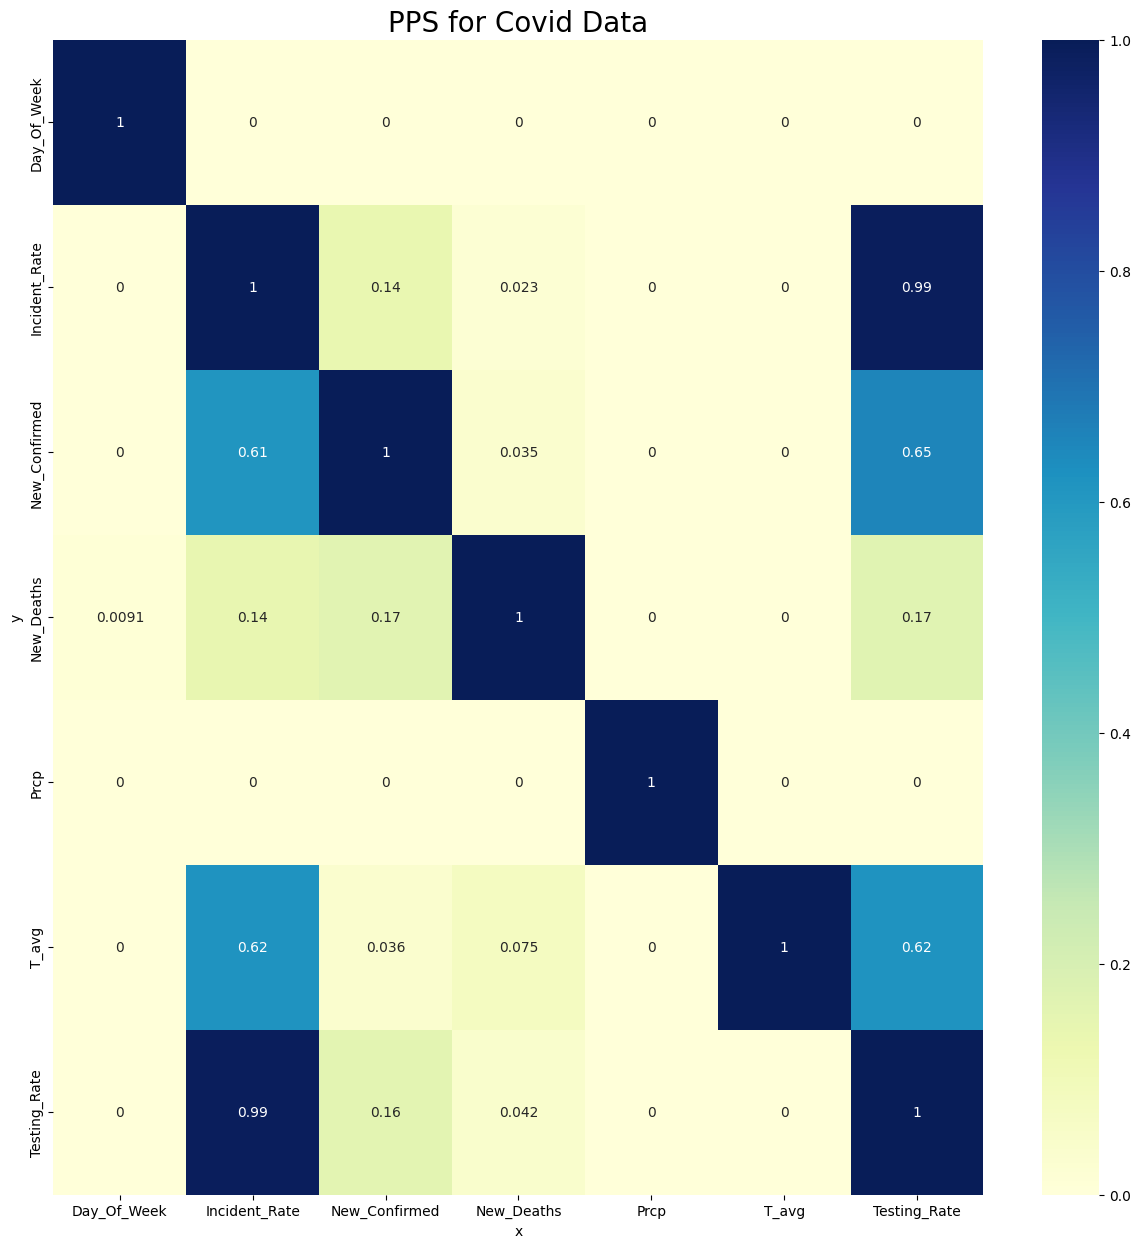

In [69]:
fig, ax = plt.subplots(figsize=(15,15))  
sns.heatmap(matrix_df, annot = True, cmap = 'YlGnBu')
ax.set_title("PPS for Covid Data", fontsize = 20)
plt.show

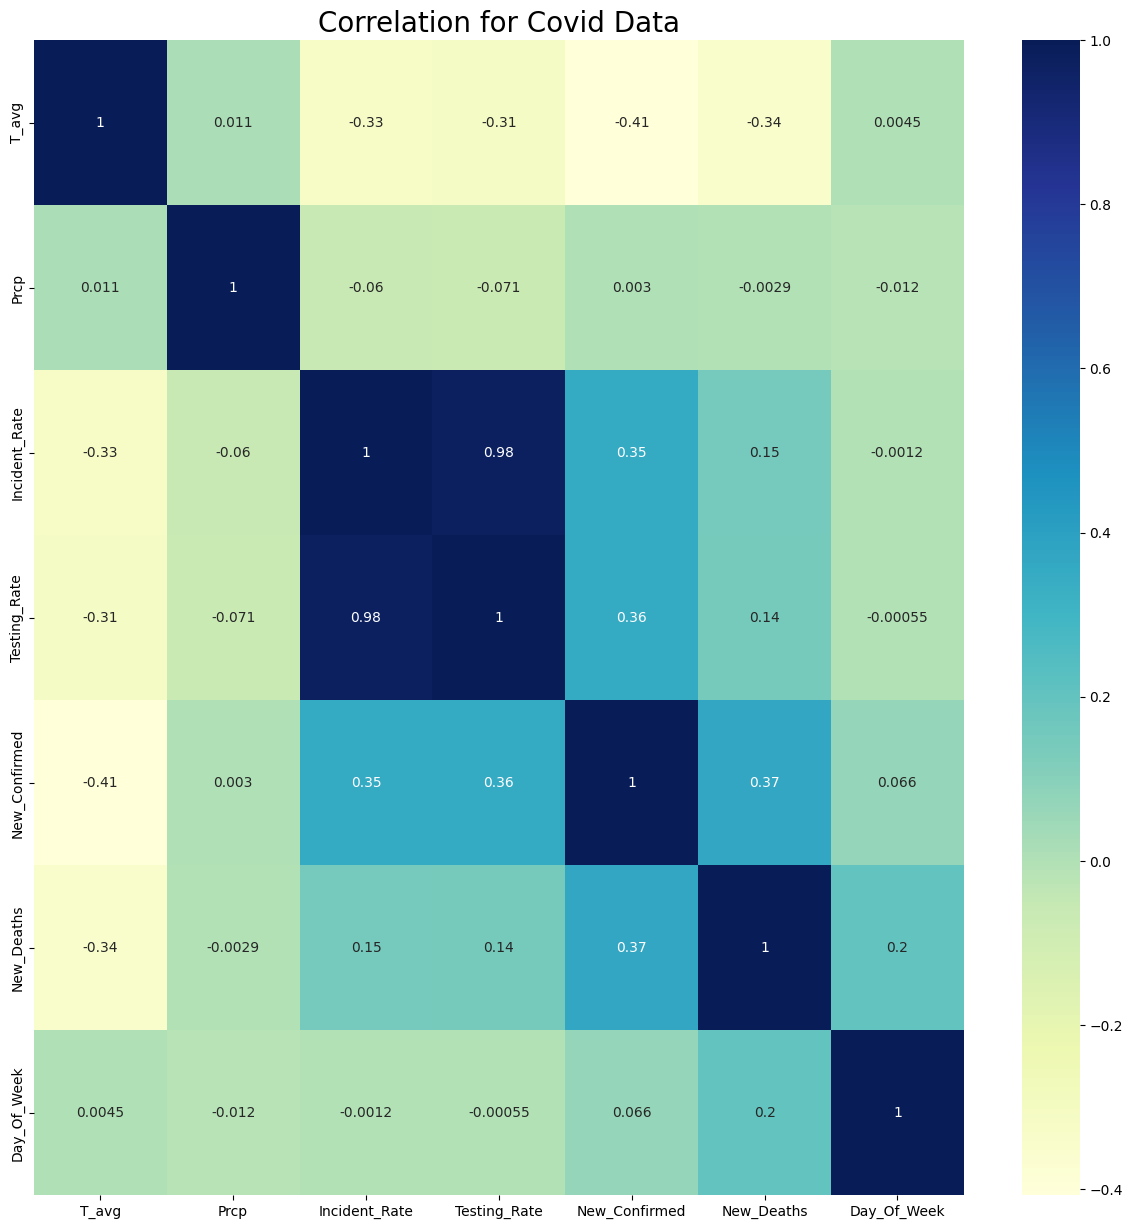

In [70]:
fig, ax = plt.subplots(figsize=(15,15))  
sns.heatmap(df.corr(), annot = True, cmap = 'YlGnBu')
ax.set_title("Correlation for Covid Data", fontsize = 20)
plt.show()

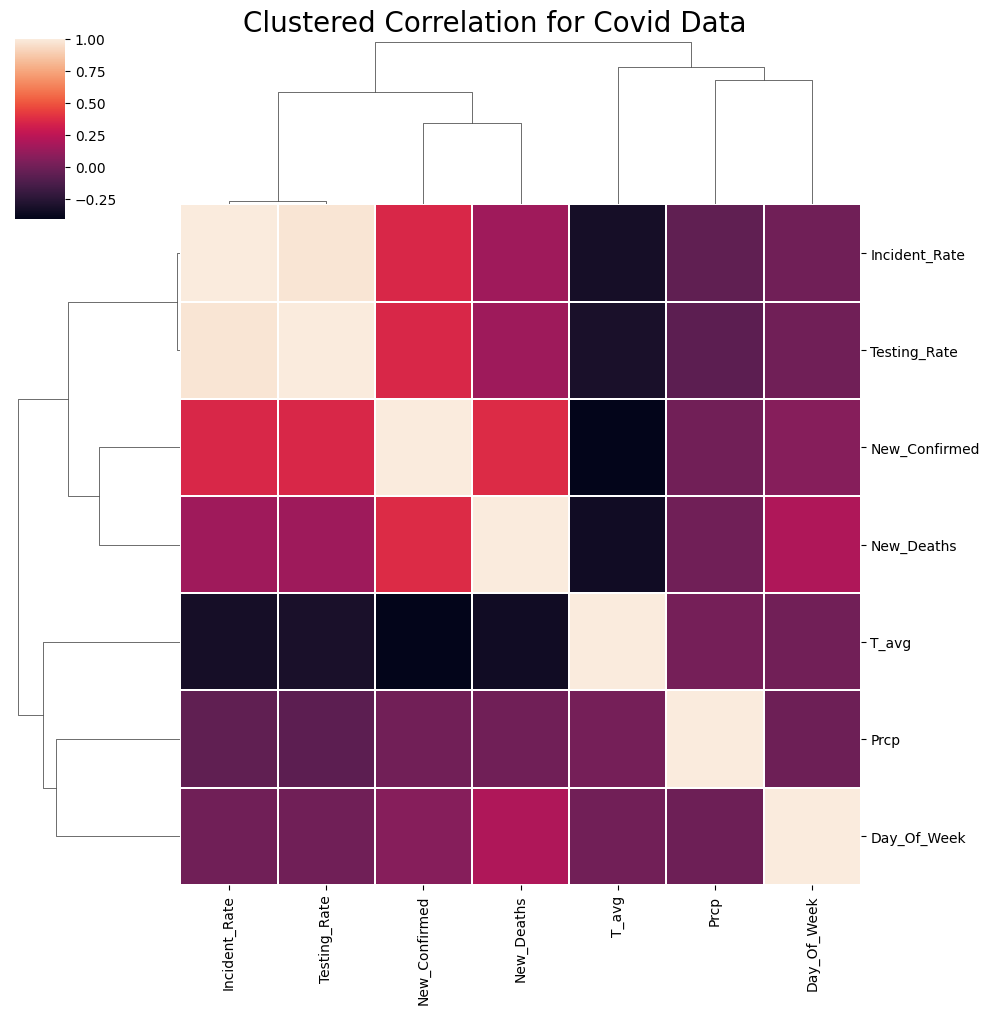

In [71]:
sns.clustermap(df.corr(), annot = False, linewidth = .1).fig.suptitle('Clustered Correlation for Covid Data', fontsize = 20, y = 1.01)
plt.show()

checking day of the week to convert to weekly and monthly

In [72]:
df.head(3)

,T_avg,Prcp,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths,Day_Of_Week
Date,,,,,,,
2020-04-12,58.46,0.559055,43.573259,626.535422,NaN,NaN,6
2020-04-13,68.90,1.468504,46.586202,639.128846,316.0,5.0,0
2020-04-14,64.94,0.000000,48.750563,655.775557,227.0,18.0,1


In [73]:
df.tail(3)

,T_avg,Prcp,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths,Day_Of_Week
Date,,,,,,,
2022-04-05,60.98,1.460630,25100.456861,217512.969957,683.666667,7.0,1
2022-04-06,70.52,0.000000,25105.929739,217931.664163,574.000000,3.0,2
2022-04-07,64.40,0.098425,25114.282075,217992.075578,876.000000,18.0,3


Dropping rows so the data starts on a Monday and ends on a Sunday (to be precise for weekly viewing)

In [74]:
df_weekly = df.copy()
df_weekly.drop(df.head(1).index,inplace=True)
df_weekly.drop(df.tail(4).index,inplace=True)

In [75]:
df_weekly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2020-04-13 to 2022-04-03
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   T_avg          720 non-null    float64
 1   Prcp           720 non-null    float64
 2   Incident_Rate  720 non-null    float64
 3   Testing_Rate   720 non-null    float64
 4   New_Confirmed  720 non-null    float64
 5   New_Deaths     720 non-null    float64
 6   Day_Of_Week    720 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 45.0 KB


In [76]:
#double checking I got the beginning of the data correct
df_weekly.head(2)

,T_avg,Prcp,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths,Day_Of_Week
Date,,,,,,,
2020-04-13,68.90,1.468504,46.586202,639.128846,316.0,5.0,0
2020-04-14,64.94,0.000000,48.750563,655.775557,227.0,18.0,1


In [77]:
#double checking I got the end of the data correct
df_weekly.tail(2)

,T_avg,Prcp,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths,Day_Of_Week
Date,,,,,,,
2022-04-02,53.42,0.0,25080.901335,217331.297118,1144.000000,8.0,5
2022-04-03,55.94,0.0,25080.901335,217512.969957,683.666667,7.0,6


changing daily updates to weekly updates

In [78]:
df_weekly = df_weekly.resample('w').mean()
df_weekly.head()

,T_avg,Prcp,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths,Day_Of_Week
Date,,,,,,,
2020-04-19,57.688571,0.231159,54.418219,713.192810,290.142857,15.857143,3.0
2020-04-26,62.300000,0.328084,73.737650,932.970352,361.166667,17.500000,3.0
2020-05-03,62.420000,0.345332,97.614180,1224.843311,402.857143,18.000000,3.0
2020-05-10,58.717143,0.063555,124.396955,1646.174926,412.857143,17.142857,3.0
2020-05-17,64.348571,0.002812,156.337965,2092.356501,521.714286,17.857143,3.0


In [79]:
df_monthly = df.copy()
df_monthly.drop(df.head(18).index,inplace=True)
df_monthly.drop(df.tail(7).index,inplace=True)

In [80]:
#double checking I got the beginning of the data correct
df_monthly.head(2)

,T_avg,Prcp,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths,Day_Of_Week
Date,,,,,,,
2020-05-01,58.46,0.0,102.535411,1290.962026,574.0,24.0,4
2020-05-02,59.36,0.0,105.548354,1349.401964,316.0,13.0,5


In [81]:
#double checking I got the end of the data correct
df_monthly.tail(2)

,T_avg,Prcp,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths,Day_Of_Week
Date,,,,,,,
2022-03-30,61.34,0.000000,25049.570541,216939.128253,624.0,4.0,2
2022-03-31,68.90,1.090551,25059.743991,217016.225271,1067.0,9.0,3


In [82]:
df_monthly = df_monthly.resample('m').mean()
df_monthly.head()

,T_avg,Prcp,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths,Day_Of_Week
Date,,,,,,,
2020-05-31,65.503226,0.212979,172.132981,2370.829924,568.193548,17.645161,3.193548
2020-06-30,75.968000,0.093832,427.269016,6077.470076,1198.066667,14.266667,2.833333
2020-07-31,82.010968,0.106299,877.642081,12392.828145,1832.129032,18.225806,3.000000
2020-08-31,79.746452,0.132461,1371.915761,18841.475471,1470.806452,24.838710,3.064516
2020-09-30,71.378000,0.148556,1786.467067,25226.661991,1433.633333,26.733333,2.900000


In [83]:
df.describe()

,T_avg,Prcp,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths,Day_Of_Week
count,725.000000,725.000000,725.000000,725.000000,724.000000,724.000000,725.000000
mean,62.559338,0.135144,8976.254839,98030.221319,3631.819061,32.000000,2.995862
std,15.001788,0.375192,7208.559871,66753.356755,5127.045079,29.593757,2.003790
min,27.500000,0.000000,43.573259,626.535422,32.000000,-3.000000,0.000000
25%,50.360000,0.000000,2190.600304,31948.781112,1185.750000,11.000000,1.000000
50%,63.860000,0.000000,8861.542299,102284.487805,1985.000000,23.000000,3.000000
75%,75.920000,0.051181,13548.556629,152162.625700,4128.500000,42.000000,5.000000
max,127.340000,4.618110,25114.282075,217992.075578,44833.000000,181.000000,6.000000


In [84]:
df_weekly.describe()

,T_avg,Prcp,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths,Day_Of_Week
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.0
mean,62.558946,0.133411,8886.842376,97366.528726,3643.524041,32.108877,3.0
std,13.882875,0.148127,7155.818609,66608.588096,4911.428313,21.943890,0.0
min,35.214286,0.000000,54.418219,713.192810,290.142857,3.511905,3.0
25%,50.987143,0.019128,2195.314498,32062.812562,1298.428571,16.535714,3.0
50%,63.377143,0.092801,8816.356325,101638.515263,1946.857143,23.428571,3.0
75%,76.048571,0.206693,13372.908994,150271.489054,4124.476190,41.928571,3.0
max,83.505714,0.714286,25058.072707,216913.463753,28710.083333,100.142857,3.0


In [85]:
df_monthly.describe()

,T_avg,Prcp,Incident_Rate,Testing_Rate,New_Confirmed,New_Deaths,Day_Of_Week
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,62.545590,0.128406,9084.173787,99625.578500,3737.132826,32.839555,2.999252
std,13.505045,0.063997,7168.867191,66395.853018,4817.712036,21.153807,0.113161
min,40.225806,0.032677,172.132981,2370.829924,376.083333,6.806452,2.806452
25%,51.417984,0.080675,2636.277026,38793.295043,1375.004839,18.179570,2.903226
50%,64.643871,0.124803,8957.696817,103685.162133,1843.933333,25.064516,3.000000
75%,74.300000,0.179516,13098.291792,148234.019643,4765.645161,45.048387,3.064516
max,82.010968,0.247857,24896.841148,214424.642720,23827.795699,82.516129,3.193548


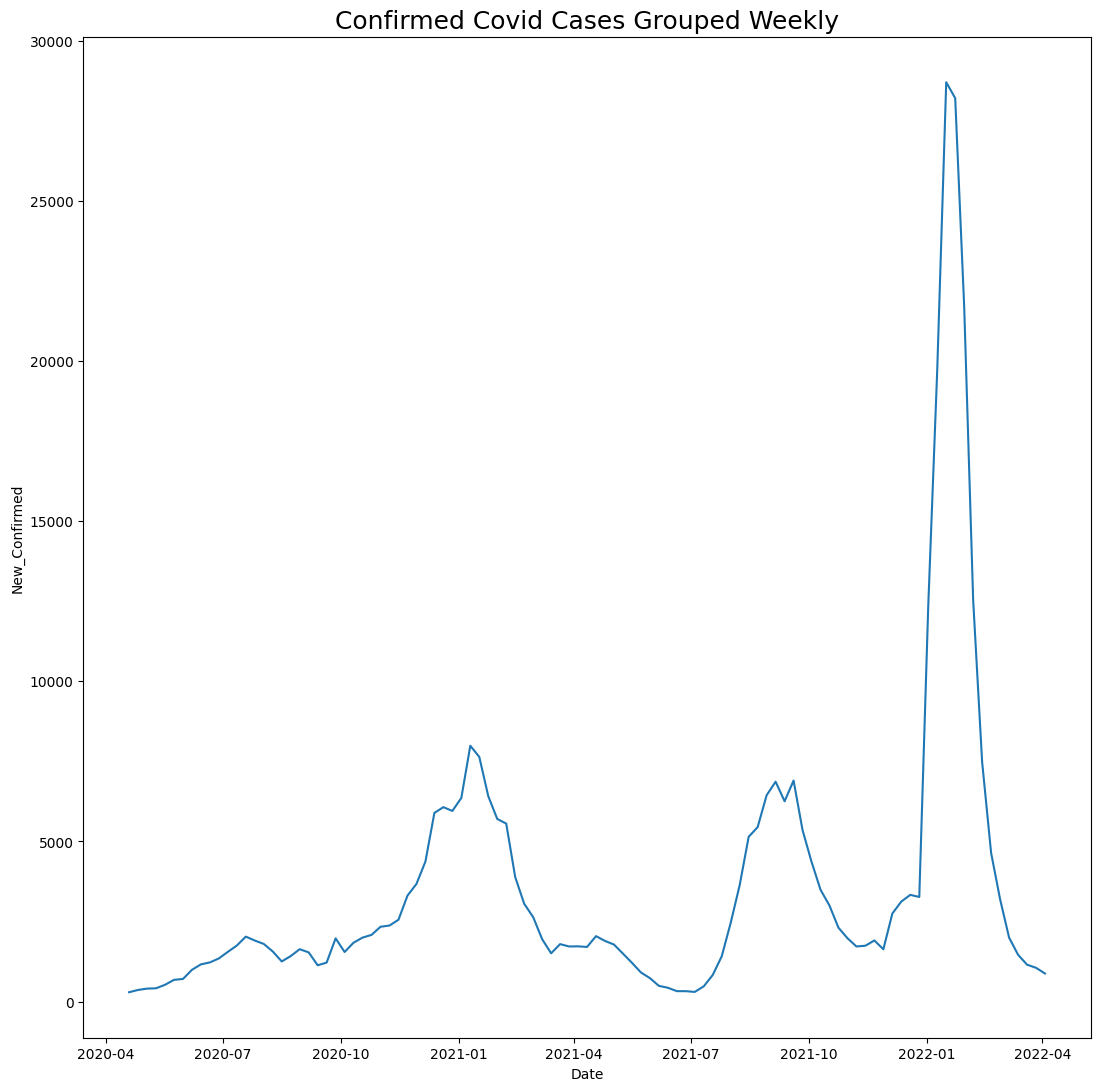

In [86]:
fig, ax = plt.subplots(figsize=(13,13))  
sns.lineplot(data = df_weekly, x='Date', y = 'New_Confirmed')
ax.set_title('Confirmed Covid Cases Grouped Weekly', fontsize= 18)
plt.show()

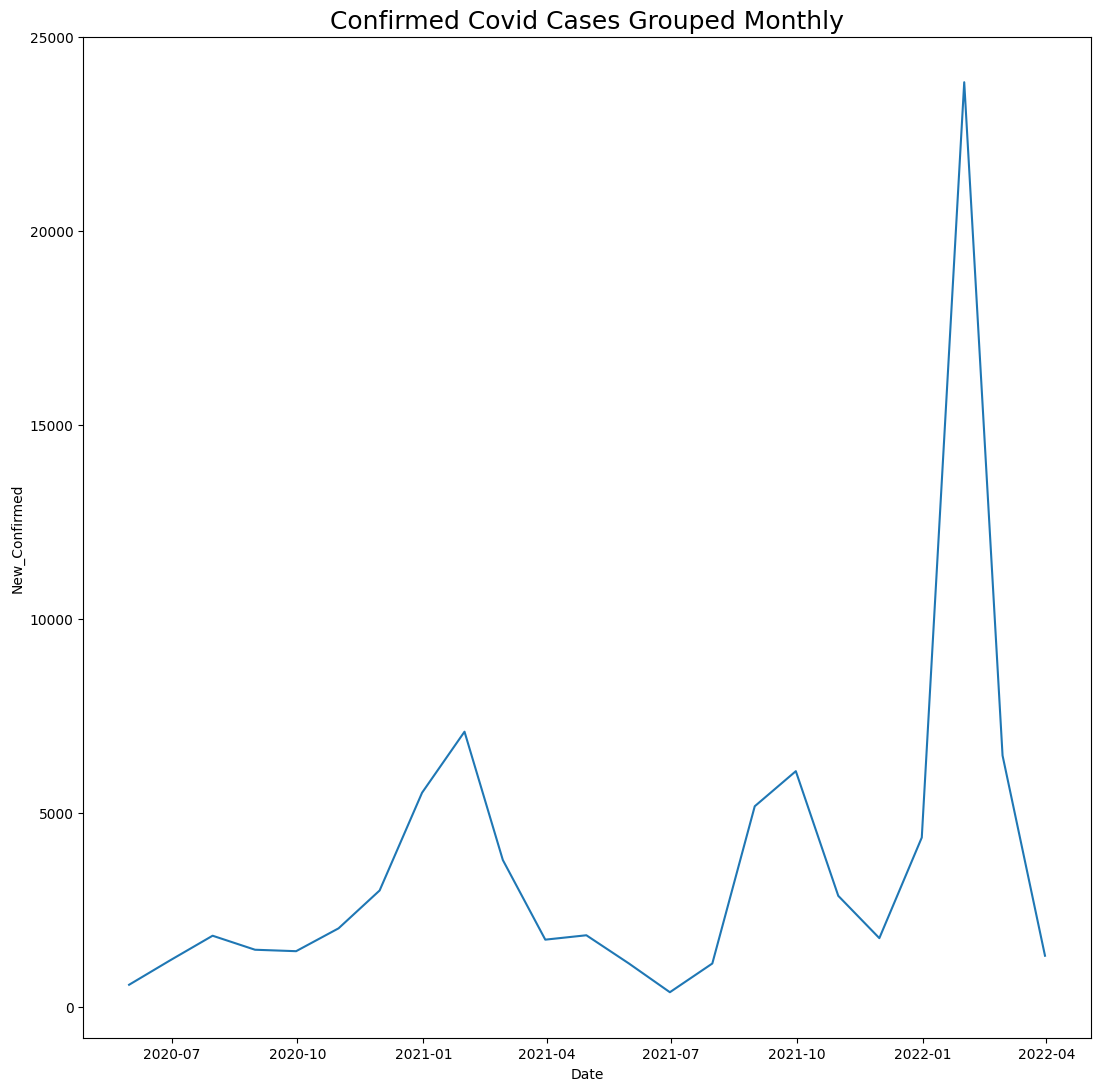

In [87]:
fig, ax = plt.subplots(figsize=(13,13))  
sns.lineplot(data = df_monthly, x='Date', y = 'New_Confirmed')
ax.set_title('Confirmed Covid Cases Grouped Monthly', fontsize= 18)
plt.show()

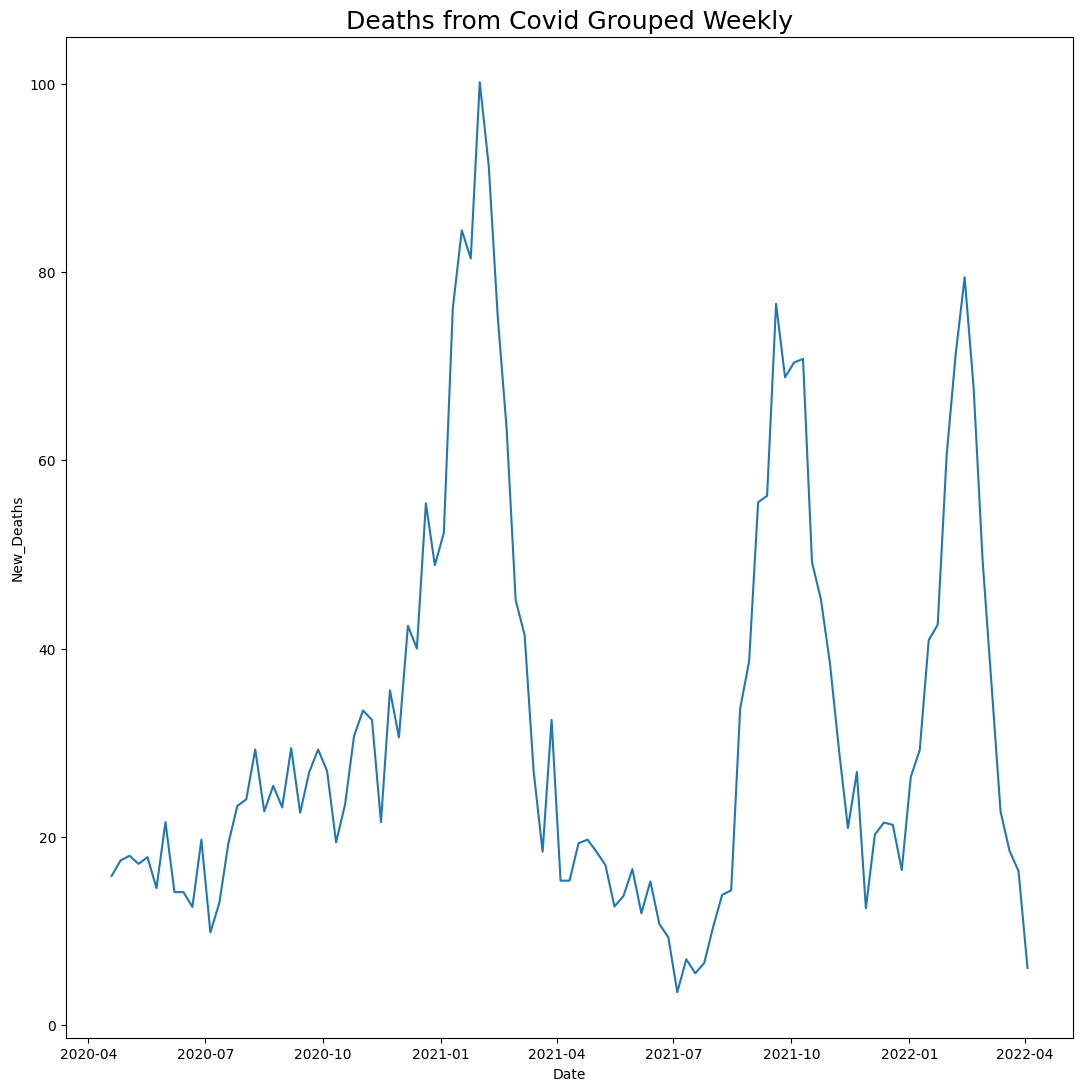

In [88]:
fig, ax = plt.subplots(figsize=(13,13))  
sns.lineplot(data = df_weekly, x = 'Date', y = 'New_Deaths')
ax.set_title('Deaths from Covid Grouped Weekly', fontsize= 18)
plt.show()

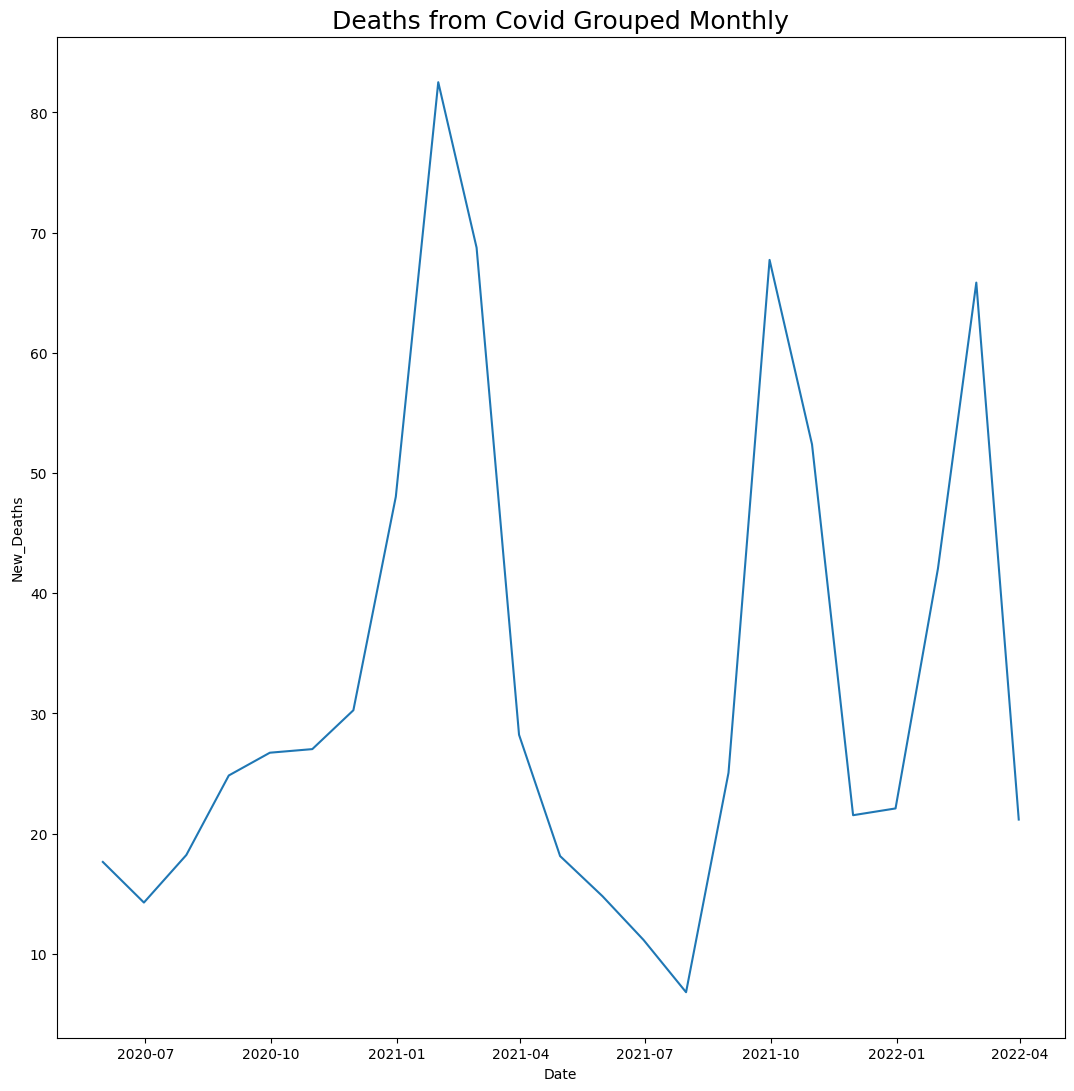

In [89]:
fig, ax = plt.subplots(figsize=(13,13))  
sns.lineplot(data = df_monthly, x = 'Date', y = 'New_Deaths')
ax.set_title('Deaths from Covid Grouped Monthly', fontsize= 18)
plt.show()

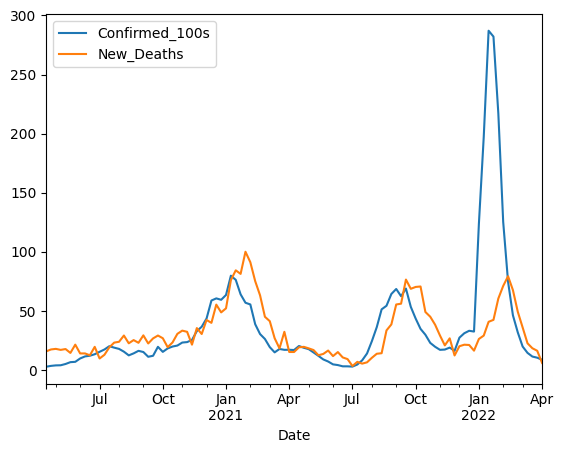

In [90]:
df_plot = df_weekly.copy()
df_plot['Confirmed_100s'] = df_plot['New_Confirmed']/100
df_plot[['Confirmed_100s', 'New_Deaths']].plot()
plt.show()

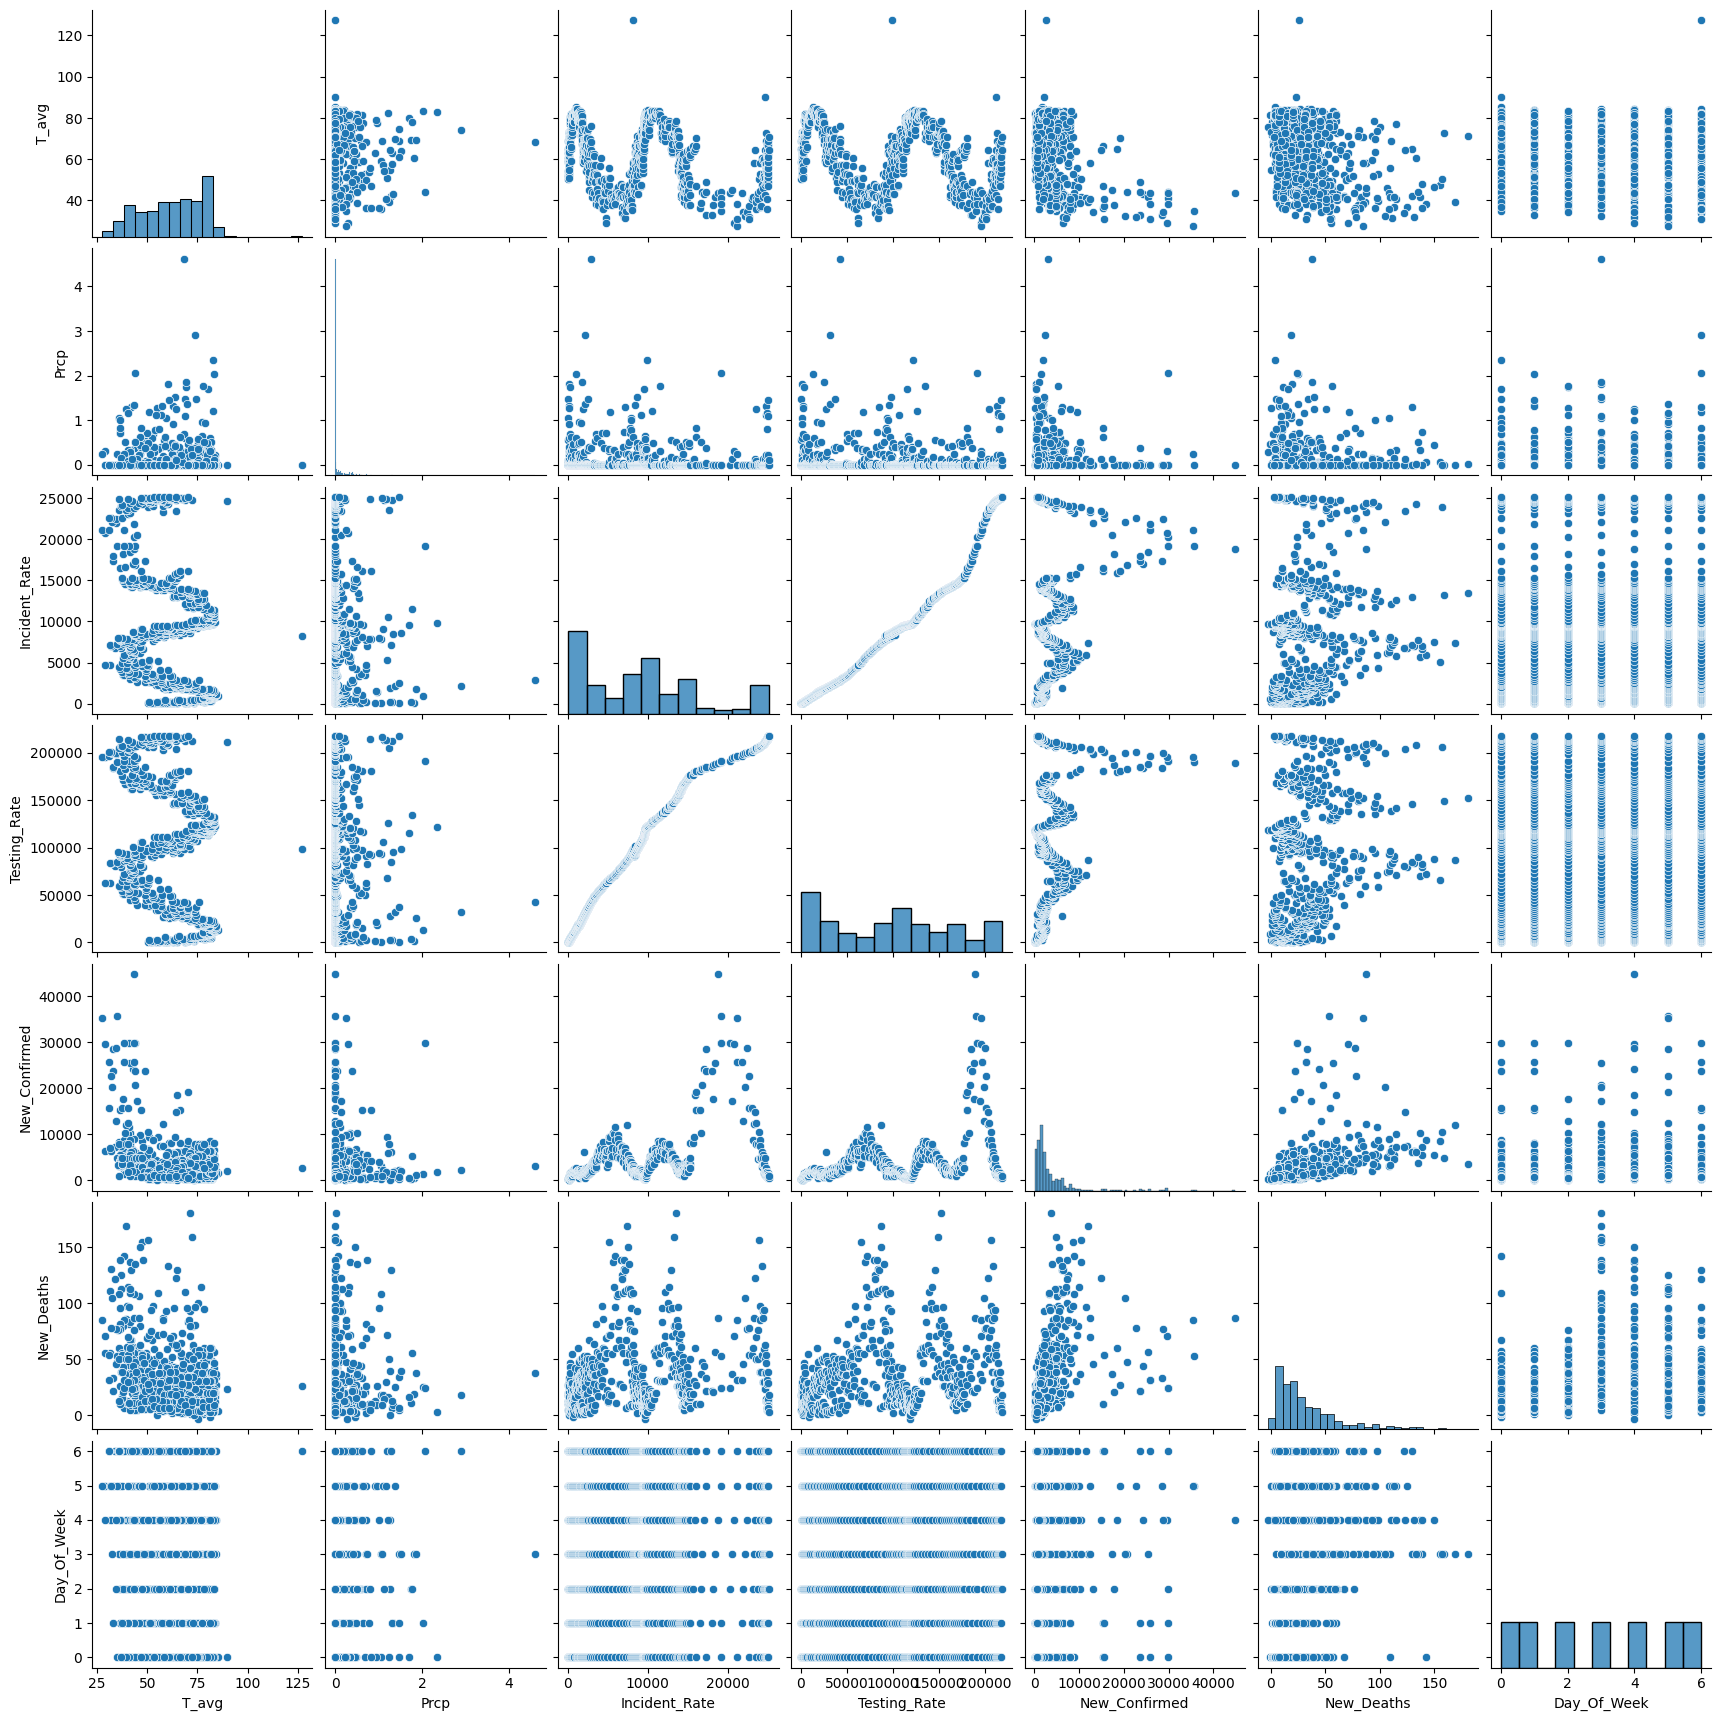

In [91]:
sns.pairplot(df)
plt.show()

In [92]:
df = df.reset_index()

In [93]:
df_weekly = df_weekly.reset_index()

In [94]:
df_monthly = df_monthly.reset_index()

In [95]:
#saving dataframe to be used in exploratory data analysis notebook
df.to_csv(r'Users\colem\OneDrive\Documents\Springboard\COVID-19-master/covid_data_posteda.csv', index = False)
df_weekly.to_csv(r'Users\colem\OneDrive\Documents\Springboard\COVID-19-master/covid_data_posteda_weekly.csv', index = False)
df_monthly.to_csv(r'Users\colem\OneDrive\Documents\Springboard\COVID-19-master/covid_data_posteda_monthly.csv', index = False)